In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw

mol = Chem.MolFromSmiles('CS(=O)CCCCCCCN=C=S')
mol = Chem.MolFromSmiles('Coc1cc(CCN)c(OC)cc1Br')
Draw.MolToImage(mol, size=(150,150), kekulize=True)
# Draw.ShowMol(mol, size=(150,150), kekulize=False)
Draw.MolToFile(mol, 'data/output.png', size=(600, 600))

In [ ]:

from utils_function import split_smiles
def test_split():
    sm = 'C(=O)CC(Br)C[N+]CN'
    pred = 'C ( = O ) C C ( Br ) C [ N + ] C N'
    assert split_smiles(sm)==pred
    print(sm)
    print(pred)
    print(split_smiles(sm)==pred)
    print(split_smiles("Coc1cc(CCN)c(OC)cc1Br"))

test_split()

print(split_smiles("O[C@@H]1C[C@@](O)(C[C@@H](O)[C@H]1OC(=O)\C=C\C1=CC(O)=C(O)C=C1)C(O)=O"))


loss 0.009, 11886.1 tokens/sec on cuda
tensor([[2]], device='cuda:0')
pred_seq: <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos>, 
label_seq: [H][C@]1([C@@H](O)[C@H](OC2=CC(O)=CC(O)=C12)C1=CC(O)=C(O)C=C1)C1=C2O[C@@H]([C@H](O)[C@@]([H])(C3=C(O)C=C(O)C4=C3O[C@@H]([C@H](O)C4)C3=CC(O)=C(O)C=C3)C2=C(O)C=C1O)C1=CC(O)=C(O)C=C1
[864.0, 379.0, 865.0, 669.0, 866.0, 999.0, 867.0, 175.0] => <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <bos> <

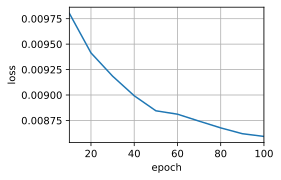

In [2]:

import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu' )
from d2l import torch as d2l
import numpy as np

from utils_function import load_data_nmt
from prepare_mass_spectra import input_mass_spectra
from prepare_smiles import output_smiles
from seq_to_seq import Seq2SeqEncoder, Seq2SeqDecoder, train_seq2seq, predict_seq2seq, bleu
import config

batch_size = config.batch_size
split_ratio = config.split_ratio
src_num_steps = config.src_num_steps
tgt_num_steps = config.tgt_num_steps
embed_size = config.embed_size
num_hiddens = config.num_hiddens
num_layers = config.num_layers
dropout = config.dropout
lr = config.lr
num_epochs = config.num_epochs
split_ratio = config.split_ratio

tensor_mass_spectra, length_new_mass_spectras, new_mass_spectras = input_mass_spectra()
tensor_smiles, smiles = output_smiles()

split_train = int(len(new_mass_spectras)*split_ratio)

train_iter, src_vocab, tgt_vocab = load_data_nmt(
    batch_size=batch_size, source=new_mass_spectras, target=smiles, 
    src_num_steps=src_num_steps, tgt_num_steps=tgt_num_steps)

# encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
# decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
# net = d2l.EncoderDecoder(encoder, decoder)
# train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab,  device)

from transformer import TransformerEncoder, TransformerDecoder

ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

src_test = new_mass_spectras[split_train:]
tgt_test = smiles[split_train:]

test_iter, src_vocab, tgt_vocab = load_data_nmt(
    batch_size=batch_size, source=new_mass_spectras[split_train:], target=smiles[split_train:], 
    src_num_steps=src_num_steps, tgt_num_steps=tgt_num_steps)

for src, tgt in zip(src_test, tgt_test):
    translation, attention_weight_seq = predict_seq2seq(net, src, src_vocab, tgt_vocab, src_num_steps, tgt_num_steps, device)
    print(f'{src} => {translation}, bleu {bleu(translation, tgt, k=2):.3f}')